<a href="https://colab.research.google.com/github/SujayVivek/TradingStrategies/blob/main/Sujay_Numatix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.7 MB/s eta 0:00:00


##Download and prepare financial Data

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs
import warnings
warnings.filterwarnings('ignore')

In [5]:
tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','NVDA','JPM','VTI','GLD', 'BTC-USD']
start_date = '2015-01-01'
end_date = '2025-01-01'
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust= False)

[*********************100%***********************]  10 of 10 completed


##Data Cleaning:

In [6]:
class PriceCleaner:
    def __init__(self, data, tickers):
        self.data = data
        self.tickers = tickers
        self.prices = None
        self.cleaned_prices = None

    def build_price_dataframe(self):
        adj_close = pd.DataFrame({ticker: self.data[ticker]['Adj Close'] for ticker in self.tickers})
        close = pd.DataFrame({ticker: self.data[ticker]['Close'] for ticker in self.tickers})
        self.prices = pd.concat({'Adjusted Close': adj_close, 'Close': close}, axis=1)

    def interpolate_and_clean(self, window=6):
        if self.prices is None:
            self.build_price_dataframe()

        prices_interp = self.prices.interpolate(method='time')
        is_na = self.prices.isna()
        long_gaps = is_na.rolling(window=window).sum() >= window
        to_drop = long_gaps.any(axis=1).shift(-(window - 1)).fillna(False)
        self.cleaned_prices = prices_interp[~to_drop]
        self.cleaned_prices.ffill().bfill()

    def get_cleaned_prices(self):
        if self.cleaned_prices is None:
            self.interpolate_and_clean()
        return self.cleaned_prices


In [7]:
cleaner = PriceCleaner(data, tickers)
cleaner.interpolate_and_clean()
prices_clean = cleaner.get_cleaned_prices()

###Use a Dataframe of Only Adjusted Close Prices & Calculate Daily Returns:

In [8]:
class ReturnCalculator:
    def __init__(self, prices_clean):
        self.prices_clean = prices_clean
        self.adj_close = None
        self.asset_returns = None

    def extract_adjusted_close(self):
        self.adj_close = self.prices_clean.xs('Adjusted Close', axis=1, level=0)

    def compute_returns(self):
        if self.adj_close is None:
            self.extract_adjusted_close()
        self.asset_returns = self.adj_close.pct_change().dropna()

    def get_returns(self):
        if self.asset_returns is None:
            self.compute_returns()
        return self.asset_returns


In [20]:
return_calc = ReturnCalculator(prices_clean)
return_calc.compute_returns()
asset_returns = return_calc.get_returns()


NameError: name 'opt_weights' is not defined

##Getting User Defined Weights:

In [10]:
def get_user_weights(tickers):
    """
    Prompt user to input comma-separated weights that sum to 1.
    Returns a pd.Series indexed by tickers.
    """
    prompt = (
        f"Enter {len(tickers)} weights (comma-separated) for:\n"
        f"{', '.join(tickers)}\n→ "
    )
    raw = input(prompt)
    w   = np.array([float(x) for x in raw.split(',')])
    if not np.isclose(w.sum(), 1):
        raise ValueError("Weights must sum to 1")
    return pd.Series(w, index=tickers)

##Getting Optimized Weights acc. Sharpe and Volume

In [11]:
from scipy.optimize import minimize

class PortfolioOptimizer:
    def __init__(self, returns, risk_free=0.0, trading_days=252):
        self.returns = returns
        self.risk_free = risk_free
        self.trading_days = trading_days

    def portfolio_performance(self, weights):
        """Return annualized (return, vol, sharpe)."""
        mean_ret = self.returns.mean() * self.trading_days
        cov_mat  = self.returns.cov() * self.trading_days
        port_ret = weights.dot(mean_ret)
        port_vol = np.sqrt(weights.dot(cov_mat).dot(weights))
        sharpe   = (port_ret - self.risk_free) / port_vol
        return port_ret, port_vol, sharpe

    def optimize_sharpe(self):
        """Maximize Sharpe ratio."""
        n     = self.returns.shape[1]
        init  = np.ones(n) / n
        bounds= ((0, 1),) * n
        cons  = {'type':'eq', 'fun': lambda w: w.sum() - 1}
        result = minimize(
            lambda w: -self.portfolio_performance(w)[2],
            init, method='SLSQP',
            bounds=bounds, constraints=cons
        )
        if not result.success:
            raise RuntimeError(result.message)
        return pd.Series(result.x, index=self.returns.columns)

    def optimize_min_vol(self):
        """Minimize annualized volatility."""
        n     = self.returns.shape[1]
        init  = np.ones(n) / n
        bounds= ((0, 1),) * n
        cons  = {'type':'eq', 'fun': lambda w: w.sum() - 1}
        result = minimize(
            lambda w: self.portfolio_performance(w)[1],
            init, method='SLSQP',
            bounds=bounds, constraints=cons
        )
        if not result.success:
            raise RuntimeError(result.message)
        return pd.Series(result.x, index=self.returns.columns)


######Calling Optimized Weights

In [12]:
optimizer = PortfolioOptimizer(asset_returns, risk_free=0.02, trading_days=252)
sharpe_weights = optimizer.optimize_sharpe()
minvol_weights = optimizer.optimize_min_vol()

######Calling User Defined weights

In [14]:
user_weights = get_user_weights(tickers)

Enter 10 weights (comma-separated) for:
AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, JPM, VTI, GLD, BTC-USD
→ 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


##Performance Metrics

In [15]:
class PortfolioPerformance:
    def __init__(self, portfolio_returns, risk_free_rate=0.03, trading_days=252):
        self.portfolio_returns = portfolio_returns
        self.risk_free_rate = risk_free_rate
        self.trading_days = trading_days

    def compute_performance_metrics(self):
        """
        Given a pd.Series of daily portfolio returns, compute:
          - Cumulative Return
          - Annualized Return
          - Annualized Volatility
          - Sharpe Ratio
          - Maximum Drawdown
          - Maximum Drawdown Duration (in trading days)
        Returns a pd.Series of metrics.
        """
        # 1. Cumulative growth series of $1
        cumulative = (1 + self.portfolio_returns).cumprod()

        # 2. Cumulative Return
        cum_return = cumulative.iloc[-1] - 1

        # 3. Annualized Return & Volatility
        ann_return = self.portfolio_returns.mean() * self.trading_days
        ann_vol    = self.portfolio_returns.std() * np.sqrt(self.trading_days)

        # 4. Sharpe Ratio
        sharpe = (ann_return - self.risk_free_rate) / ann_vol

        # 5. Drawdowns
        running_max   = cumulative.cummax()
        drawdown      = cumulative / running_max - 1
        max_drawdown  = drawdown.min()

        # 6. Drawdown duration
        durations     = (drawdown < 0).astype(int)
        max_dur = 0
        curr_dur = 0
        for d in durations:
            if d:
                curr_dur += 1
                max_dur = max(max_dur, curr_dur)
            else:
                curr_dur = 0

        # Pack into Series
        metrics = pd.Series({
            'Cumulative Return':           cum_return,
            'Annualized Return':           ann_return,
            'Annualized Volatility':       ann_vol,
            'Sharpe Ratio':                sharpe,
            'Maximum Drawdown':            max_drawdown,
            'Max Drawdown Duration (days)': max_dur
        })

        return metrics


In [22]:
#Choosing opt_weights as Sharpe weights as an example
portfolio_returns = asset_returns.dot(sharpe_weights)

In [23]:
portfolio_perf = PortfolioPerformance(portfolio_returns, risk_free_rate=0.03, trading_days=252)
metrics = portfolio_perf.compute_performance_metrics()

##Correlation Analysis:

In [17]:
class CorrelationAnalysis:
    def __init__(self, asset_returns, window=60, base_asset=None):
        self.asset_returns = asset_returns
        self.window = window
        self.base_asset = base_asset

    def compute_correlation(self):
        static_corr = self.asset_returns.corr()
        rolling_corr = self.asset_returns.rolling(self.window).corr()

        rolling_vs_base = None
        if self.base_asset is not None:
            rolling_vs_base = self.asset_returns[self.base_asset].rolling(self.window).corr(self.asset_returns)

            plt.figure(figsize=(12, 6))
            for ticker in self.asset_returns.columns:
                if ticker == self.base_asset:
                    continue
                plt.plot(rolling_vs_base[ticker], label=f"{self.base_asset} ↔ {ticker}")
            plt.title(f"{self.window}-Day Rolling Correlation vs {self.base_asset}")
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.legend(loc="upper right", ncol=2)
            plt.grid(True)
            plt.show()

        return static_corr, rolling_corr, rolling_vs_base

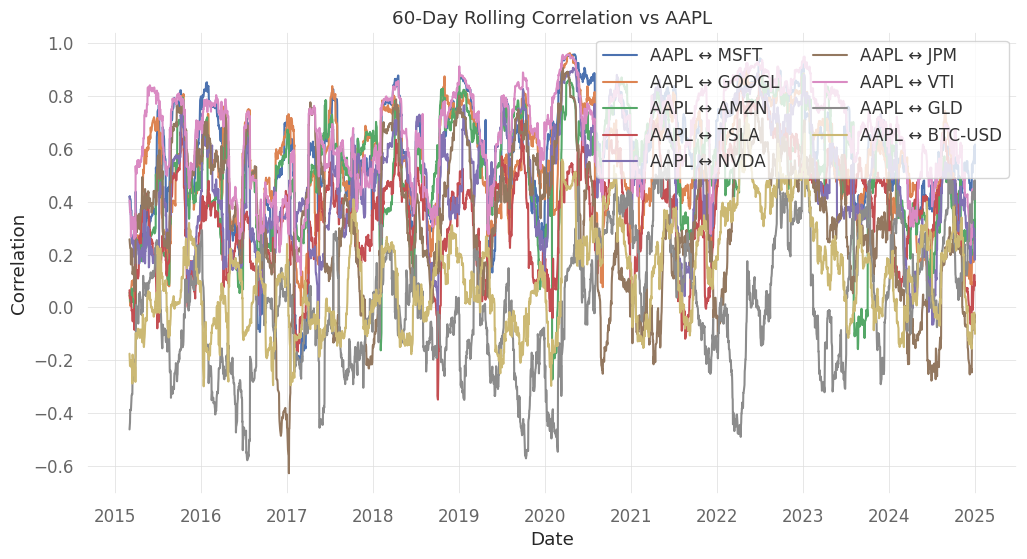

In [18]:
correlation = CorrelationAnalysis(asset_returns, window=60, base_asset='AAPL')
static_corr, rolling_corr, rolling_vs_base = correlation.compute_correlation()

##Plotting Performance:

In [41]:
class PortfolioPerformancePlotter:
    def __init__(self, rolling_window=60, trading_days=252):
        self.rolling_window = rolling_window
        self.trading_days = trading_days

    def plot_performance_charts(self, asset_returns, portfolio_returns):
        # Cumulative returns calculation
        cumulative = (1 + portfolio_returns).cumprod()

        # Correlation matrix
        corr_matrix = asset_returns.corr()

        # Rolling volatility for assets and portfolio (using pandas' rolling method)
        rolling_vol_assets = asset_returns.rolling(window=self.rolling_window).std() * np.sqrt(self.trading_days)
        rolling_vol_port = portfolio_returns.rolling(window=self.rolling_window).std() * np.sqrt(self.trading_days)

        # Cumulative maximum for drawdown calculation
        running_max = cumulative.cummax()
        drawdown = cumulative / running_max - 1

        # Plotting cumulative returns
        plt.figure(figsize=(10, 5))
        plt.plot(cumulative.index, cumulative.values, label='Portfolio')
        plt.title("Portfolio Cumulative Return")
        plt.xlabel("Date")
        plt.ylabel("Growth of $1")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plotting correlation heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, interpolation='none')
        ax.set_xticks(np.arange(len(corr_matrix)))
        ax.set_yticks(np.arange(len(corr_matrix)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
        ax.set_yticklabels(corr_matrix.index)
        fig.colorbar(cax, ax=ax, label='Correlation')
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                text = f"{corr_matrix.values[i, j]:.2f}"
                color = "w" if abs(corr_matrix.values[i, j]) > 0.5 else "k"
                ax.text(j, i, text, ha="center", va="center", color=color)
        ax.set_title("Asset Return Correlation Heatmap")
        plt.tight_layout()
        plt.show()

        # Plotting rolling volatility
        plt.figure(figsize=(12, 6))
        for ticker in rolling_vol_assets.columns:
            plt.plot(rolling_vol_assets.index, rolling_vol_assets[ticker], alpha=0.6, label=ticker)
        plt.plot(rolling_vol_port.index, rolling_vol_port, color='k', lw=2, linestyle='--', label='Portfolio')
        plt.title(f"{self.rolling_window}-Day Rolling Volatility")
        plt.xlabel("Date")
        plt.ylabel("Annualized Volatility")
        plt.legend(ncol=2, fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plotting drawdown
        plt.figure(figsize=(10, 5))
        plt.plot(drawdown.index, drawdown.values, color='crimson', label='Drawdown')
        plt.fill_between(drawdown.index, drawdown.values, 0, color='crimson', alpha=0.3)
        plt.title("Portfolio Drawdown Curve")
        plt.xlabel("Date")
        plt.ylabel("Drawdown")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


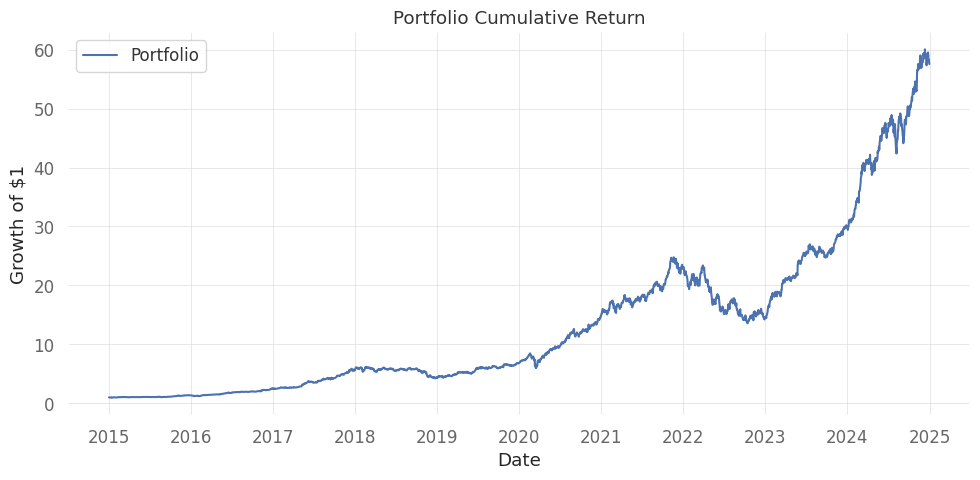

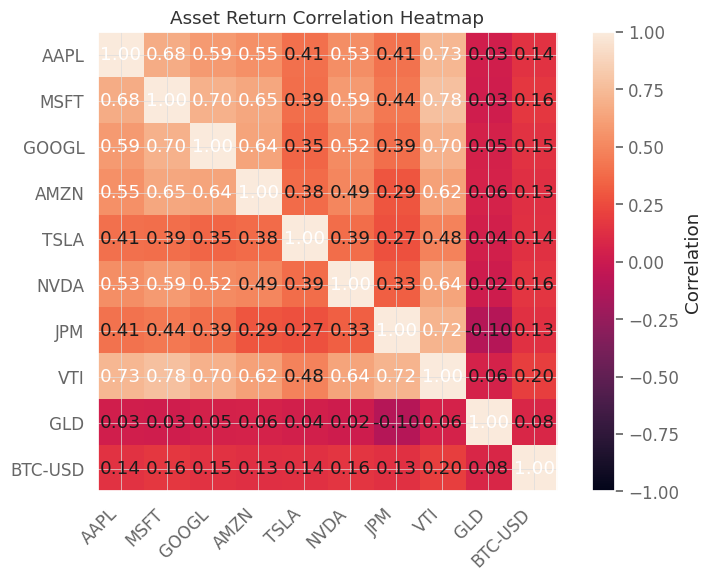

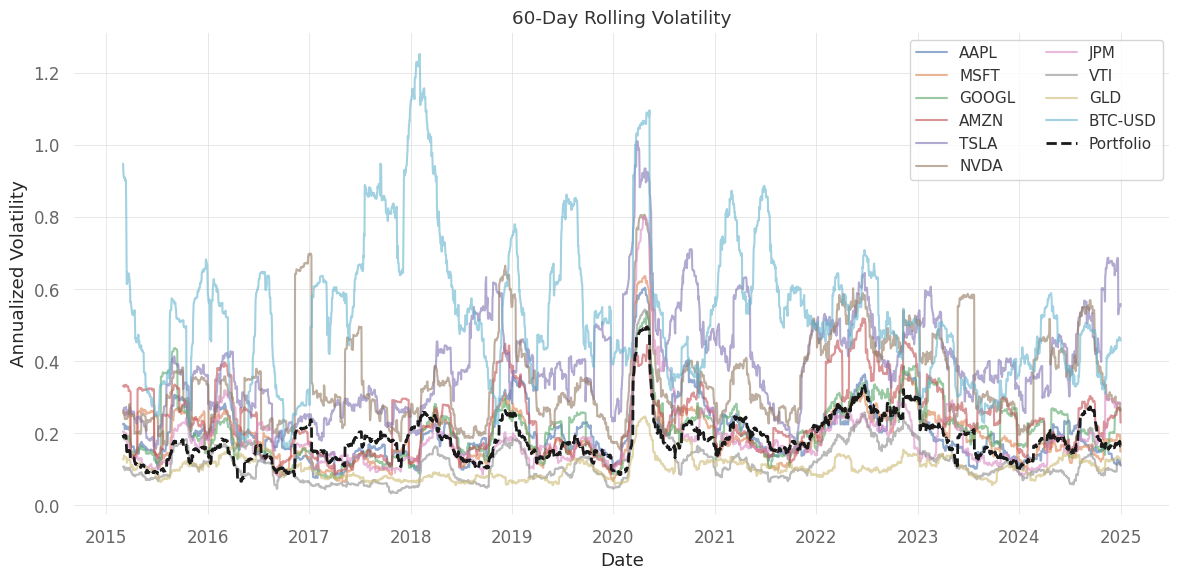

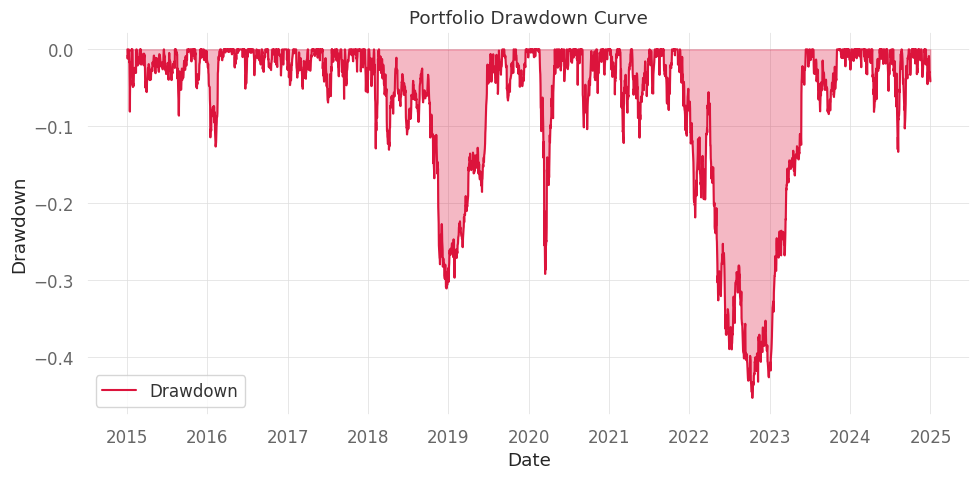

In [24]:
plotter = PortfolioPerformancePlotter(asset_returns, portfolio_returns, rolling_window=60, trading_days=252)
plotter.plot_performance_charts()

#In Order To Organize Everything

In [37]:
class PortfolioAnalysis:
    def __init__(self, asset_returns, adj_close_prices):
        self.asset_returns = asset_returns
        self.adj_close_prices = adj_close_prices
        self.performance_metrics = None  # This will be initialized later
        self.correlation_analysis = CorrelationAnalysis(self.asset_returns)
        self.performance_charts = PortfolioPerformancePlotter()  # No need to pass asset_returns here

    def run_full_analysis(self, weights, label):
        print(f"\n{'='*60}")
        print(f"🔍 Full Analysis for: {label}")
        print(f"{'='*60}")

        # 1. Calculate portfolio returns
        portfolio_returns = self.asset_returns.dot(weights)

        # 2. Performance metrics
        # Initialize PortfolioPerformance with portfolio_returns
        self.performance_metrics = PortfolioPerformance(portfolio_returns)
        perf_metrics = self.performance_metrics.compute_performance_metrics()
        print("\n📊 Performance Metrics:")
        display(perf_metrics)

        # 3. Correlation + rolling correlation
        print("\n🔗 Correlation Analysis:")
        self.correlation_analysis.compute_correlation()

        # 4. Plot all performance visualizations
        print("\n📈 Generating Plots...")
        self.performance_charts.plot_performance_charts(self.asset_returns, portfolio_returns)

        # 5. QuantStats Tear Sheet
        print("\n📄 Generating QuantStats Tear Sheet...")
        qs.extend_pandas()  # Extends pandas to use QuantStats functionality
        qs.reports.html(portfolio_returns, output=f'{label}_tear_sheet.html')

        print(f"Tear sheet saved as '{label}_tear_sheet.html'")


In [27]:
adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})


🔍 Full Analysis for: User Portfolio

📊 Performance Metrics:


,0
Cumulative Return,23.519958
Annualized Return,0.236061
Annualized Volatility,0.173810
Sharpe Ratio,1.185554
Maximum Drawdown,-0.407834
Max Drawdown Duration (days),723.000000



🔗 Correlation Analysis:

📈 Generating Plots...


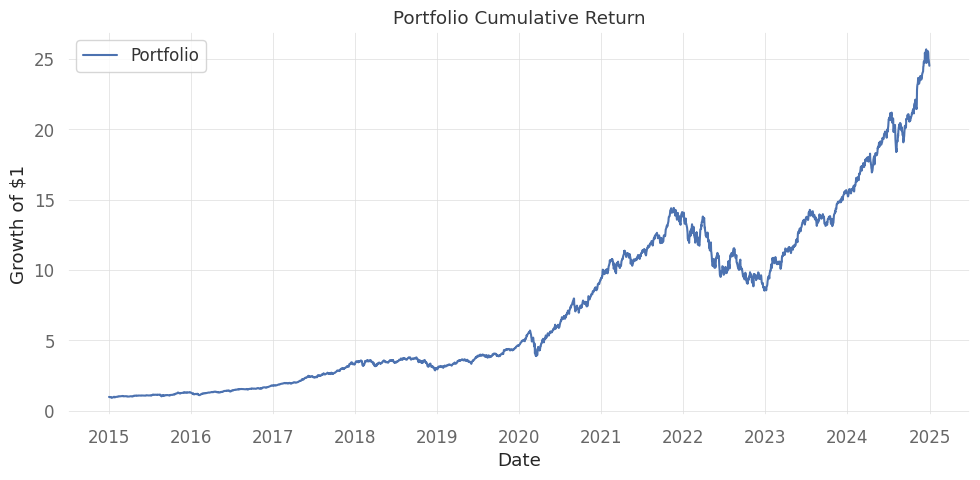

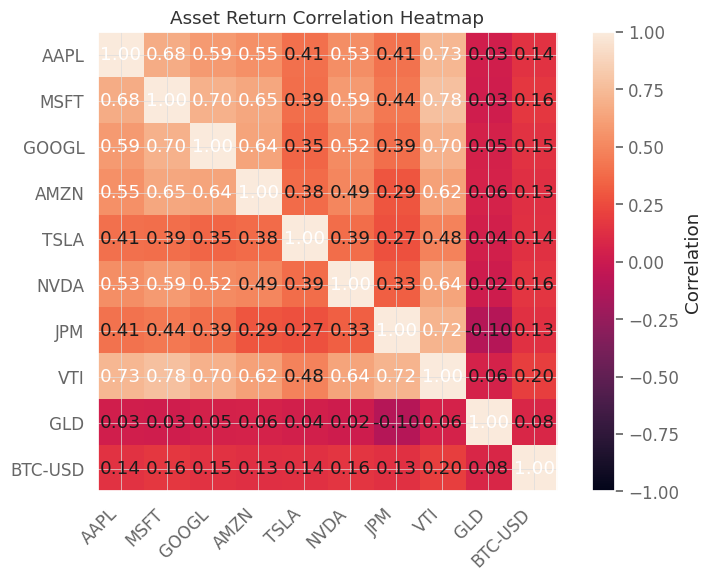

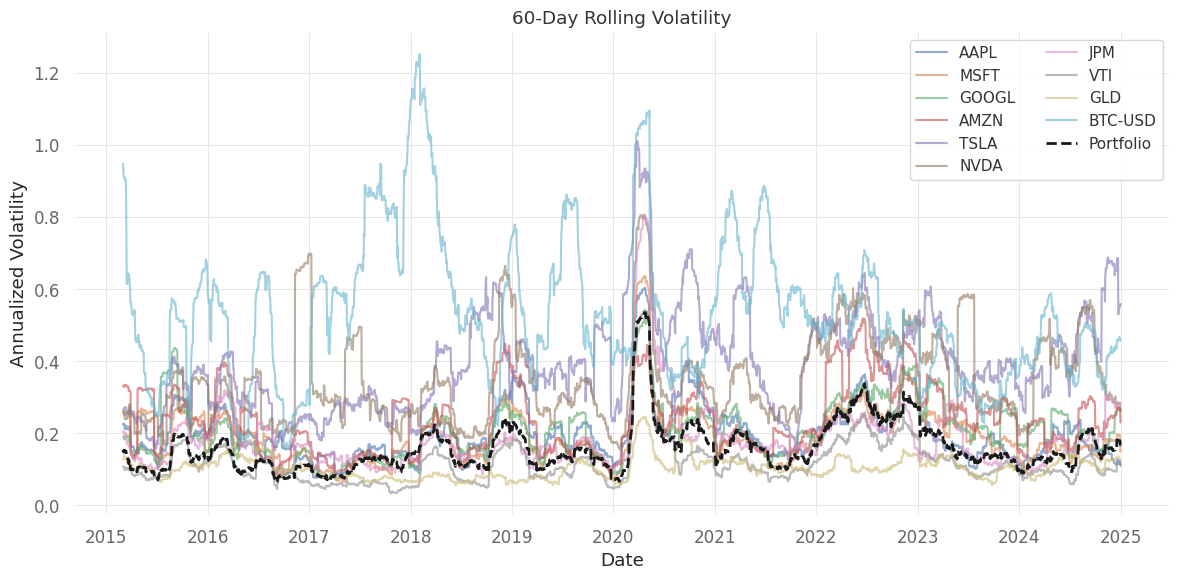

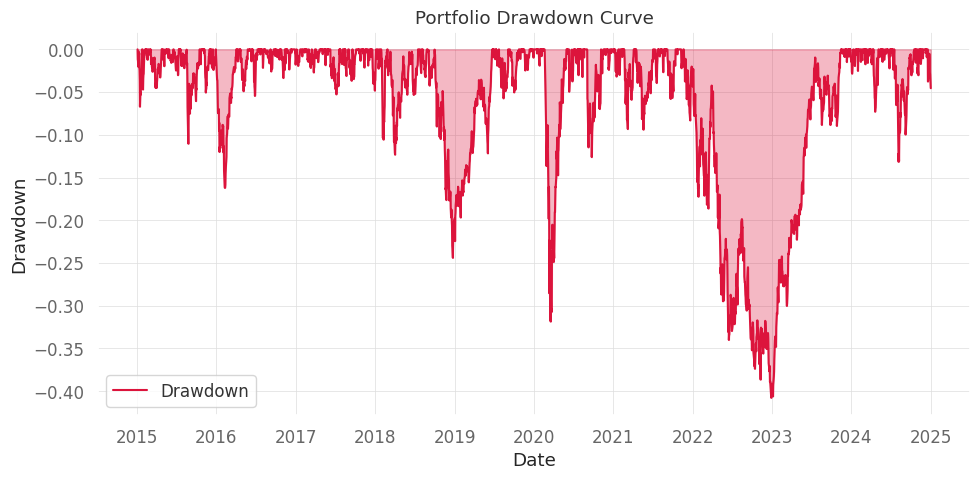


📄 Generating QuantStats Tear Sheet...


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [42]:
portfolio_analysis = PortfolioAnalysis(asset_returns, adj_close)


portfolio_analysis.run_full_analysis(user_weights, "User Portfolio")
portfolio_analysis.run_full_analysis(sharpe_weights, "Sharpe-Optimal")
portfolio_analysis.run_full_analysis(minvol_weights, "Minimum-Volatility")
